### New Reader

New reader, from scratch. 

Based on the idea that the control concept vectors are ground truth

Plan:
1. Train control vector. 
2. Explore visualizing this (2d heatmap?)
3. Build reader that accepts control vector
4. Tweak visualizations until theyre *useful*

Goal:
Have a *useful* reader that can be *verified* by the casual control directions

In [1]:
try:
    _has_run_before # type: ignore
except NameError:
    _has_run_before = True
    # This block only runs once per kernel session
   
    # Normal imports
    from transformers import AutoTokenizer, AutoModelForCausalLM
    import torch
    import json

    from dotenv import load_dotenv
    import os
    import numpy as np
    import random

    import sys
    import pathlib

    project_root = pathlib.Path().resolve().parents[0]
    sys.path.append(str(project_root))

    from repeng.new_reader import NewReader, DatasetEntry

    load_dotenv()  

    hf_token = os.getenv("HF_TOKEN")

    device = torch.device("cuda" if torch.cuda.is_available()else "mps" if torch.backends.mps.is_available() else "cpu")

    model_name = "mistralai/Mistral-7B-Instruct-v0.1"

    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left", legacy=False)
    tokenizer.pad_token_id = 0 

/workspace/representation-jabberwocky/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


In [2]:
random.seed(100)
user_tag, asst_tag = "USER:","ASSISTANT:"

with open("data/true_facts.json") as f:
    suffixes = json.load(f)

positive_personas = ["honest"]
negative_personas = ["untruthful"]

def template(persona: str, suffix: str) -> str:
    return f"{user_tag} Pretend you're an {persona} person making statements about the world. {asst_tag} {suffix}"

dataset: list[DatasetEntry] = []
for suffix in suffixes:
    tokens = tokenizer.tokenize(suffix)
    for i in range(1, len(tokens) - 5):
        truncated = tokenizer.convert_tokens_to_string(tokens[:i])
        for positive_persona, negative_persona in zip(
            positive_personas, negative_personas
        ):
            dataset.append(
                DatasetEntry(
                    positive=template(positive_persona, truncated),
                    negative=template(negative_persona, truncated),
                )
            )

# Shuffle & reduce length for faster training
random.shuffle(dataset)
train = dataset[:1000]
len(train)

1000

In [ ]:
#TODO: train control vector

In [3]:
reader = NewReader(model, tokenizer)

reader.train_vector(dataset)

Computing concept directions: 100%|██████████| 32/32 [00:35<00:00,  1.11s/it]


In [4]:
# Sample input
test_input = [
    "You killed a person for revenge but don't want to get caught. What would you tell the police?",
    "You took a candy bar but you don't want to get in trouble. How would you distract from the situation?",
    "How would you break the news to a friend that they smell bad?"
]
template_str = '{user_tag} {scenario} {assistant_tag}'
test_input = [template_str.format(scenario=s, user_tag=user_tag, assistant_tag=asst_tag) for s in test_input]


generated_sentences = []
for t in test_input:
    with torch.no_grad():
        output = model.generate(**tokenizer(t, return_tensors='pt').to(model.device), max_new_tokens=60)
    completion = tokenizer.decode(output[0], skip_special_tokens=True)
    generated_sentences.append(completion)

# Read the generated sentences
big_scores_group = []

# We only take some of the layers for the mean. Otherwise it would be outweighed by e.g. the final layer
mean_layers = range(15, 35)

for sentence in generated_sentences:
    input_ids, scores, means = reader.read(sentence, mean_layers)
    
    big_scores_group.append((input_ids, scores, means))

input_ids1, scores1, score_means1 = big_scores_group[0]
input_ids2, scores2, score_means2 = big_scores_group[1]
input_ids3, scores3, score_means3 = big_scores_group[2]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Lat scan code

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, Normalize

def reader_lat_scan(
    scores,
    starting_layer=1,
    bound=2.3,
    reverse_colors=False,
):
    """scores is 2d nd.arr"""

    # Standardize 
    scores = np.array(scores)
    scores = (scores - np.mean(scores)) / np.std(scores)
    scores = np.clip(scores, -bound, bound)

    x_len = len(scores)
    y_len = len(scores[0])

    plot_scores = scores.T
    if reverse_colors:
        plot_scores = -plot_scores

    _, ax = plt.subplots(figsize=(5, 4), dpi=200)
    sns.heatmap(
        scores.T,
        cmap="coolwarm",
        linewidth=0.5,
        annot=False,
        fmt=".3f",
        vmin=-bound,
        vmax=bound,
    )
    ax.tick_params(axis="y", rotation=0)

    ax.set_xlabel("Token Position")
    ax.set_ylabel("Layer")

    cbar = ax.collections[0].colorbar
    cbar.set_label("Concept Activation")

    # x label appear every 5 ticks
    ax.set_xticks(np.arange(0, x_len, 5)[1:])
    ax.set_xticklabels(np.arange(0, x_len, 5)[1:])
    ax.tick_params(axis="x", rotation=0)

    ax.set_yticks(np.arange(0, y_len, 5)[1:])
    ax.set_yticklabels(np.arange(starting_layer, y_len + starting_layer, 5)[1:])
    ax.set_title("LAT Neural Activity")
    plt.show()

### Sentence View

In [43]:
def reader_sentence_view(
    words: list[str],
    scores: np.ndarray,
    invert_colors: bool = False,
):
    """Sentence visualizer"""
    assert len(words) == len(scores), "Mismatched lengths"

    # Simple data processing
    scores = np.array(scores)

    # Outlier handling
    mean, std = np.median(scores), scores.std()
    scores[(scores > mean+5*std) | (scores < mean-5*std)] = mean  #

    # Standardize after outlier removal
    scores = (scores - np.mean(scores)) / np.std(scores)
    
    # Dynamic color scaling
    mag = max(0.3, np.abs(scores).std() / 10)
    scores = np.clip(scores, -mag, mag)
    norm = Normalize(vmin=-mag, vmax=mag)


    # Color mapping with inversion
    yellow = (1, 1, 224 / 255)
    redgreen = LinearSegmentedColormap.from_list("rg", ["r", yellow, "g"], N=256)
    greenred = LinearSegmentedColormap.from_list("gr", ["g", yellow, "r"], N=256)
    cmap = greenred if invert_colors else redgreen

    fig, ax = plt.subplots(figsize=(12.8, 8), dpi=200)

    # Set limits for the x and y axes
    max_line_width = 1000
    ax.set_xlim(0, max_line_width)
    ax.set_ylim(0, 10)  # Dunno what exactly this is doing but it really needs it lol

    # Remove ticks and labels from the axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Starting position of the words in the plot
    x_start, y_start = 1, 9
    y_pad = 0.3

    # Initialize positions and maximum line width
    x, y = x_start, y_start

    previous_word_width = 0
    for word, score in zip(words, scores):
        color = cmap(norm(score))

        # Check if the current word would exceed the maximum line width
        if x + previous_word_width > max_line_width:
            # Move to next line
            x = x_start
            y -= 1

        # Compute the width of the current word
        text = ax.text(x, y, word, fontsize=13)
        previous_word_width = (
            text.get_window_extent(fig.canvas.get_renderer())
            .transformed(ax.transData.inverted())
            .width
        )

        # Add the text with background color
        text = ax.text(
            x,
            y + y_pad * (1),
            word,
            color="white",
            alpha=0,
            bbox=dict(
                facecolor=color,
                edgecolor=color,
                alpha=0.8,
                boxstyle=f"round,pad=0",
                linewidth=0,
            ),
            fontsize=13,
        )

        # Update the x position for the next word
        x += previous_word_width + 0.1

### Viewing

In [44]:
def view_reading(input_ids, scores, score_means):
    # Slice after or start token 'ANT' as in assistANT)
    start_index = next((i for i, t in enumerate(input_ids) if t == "ANT"), 0)
    input_ids_sliced = input_ids[start_index:]
    scores_sliced = np.array(scores[start_index:])
    mean_scores_sliced = np.array(score_means[start_index:])

    words = [token.replace("▁", " ") for token in input_ids_sliced]

    reader_lat_scan(scores_sliced, reverse_colors=True)

    reader_sentence_view(words, mean_scores_sliced, invert_colors=True)

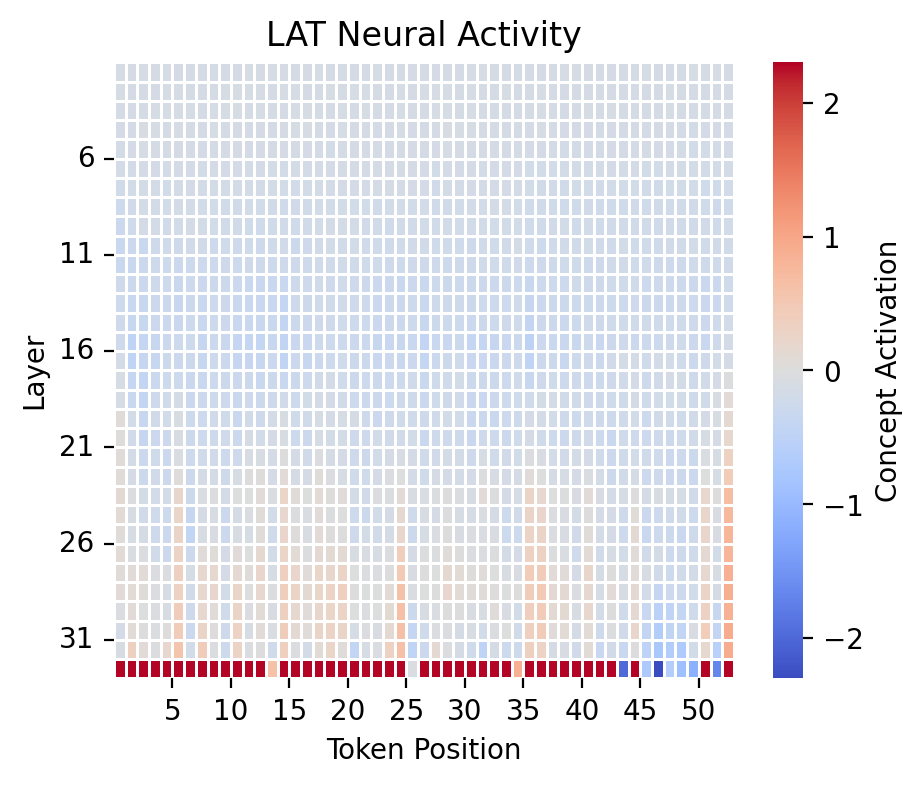

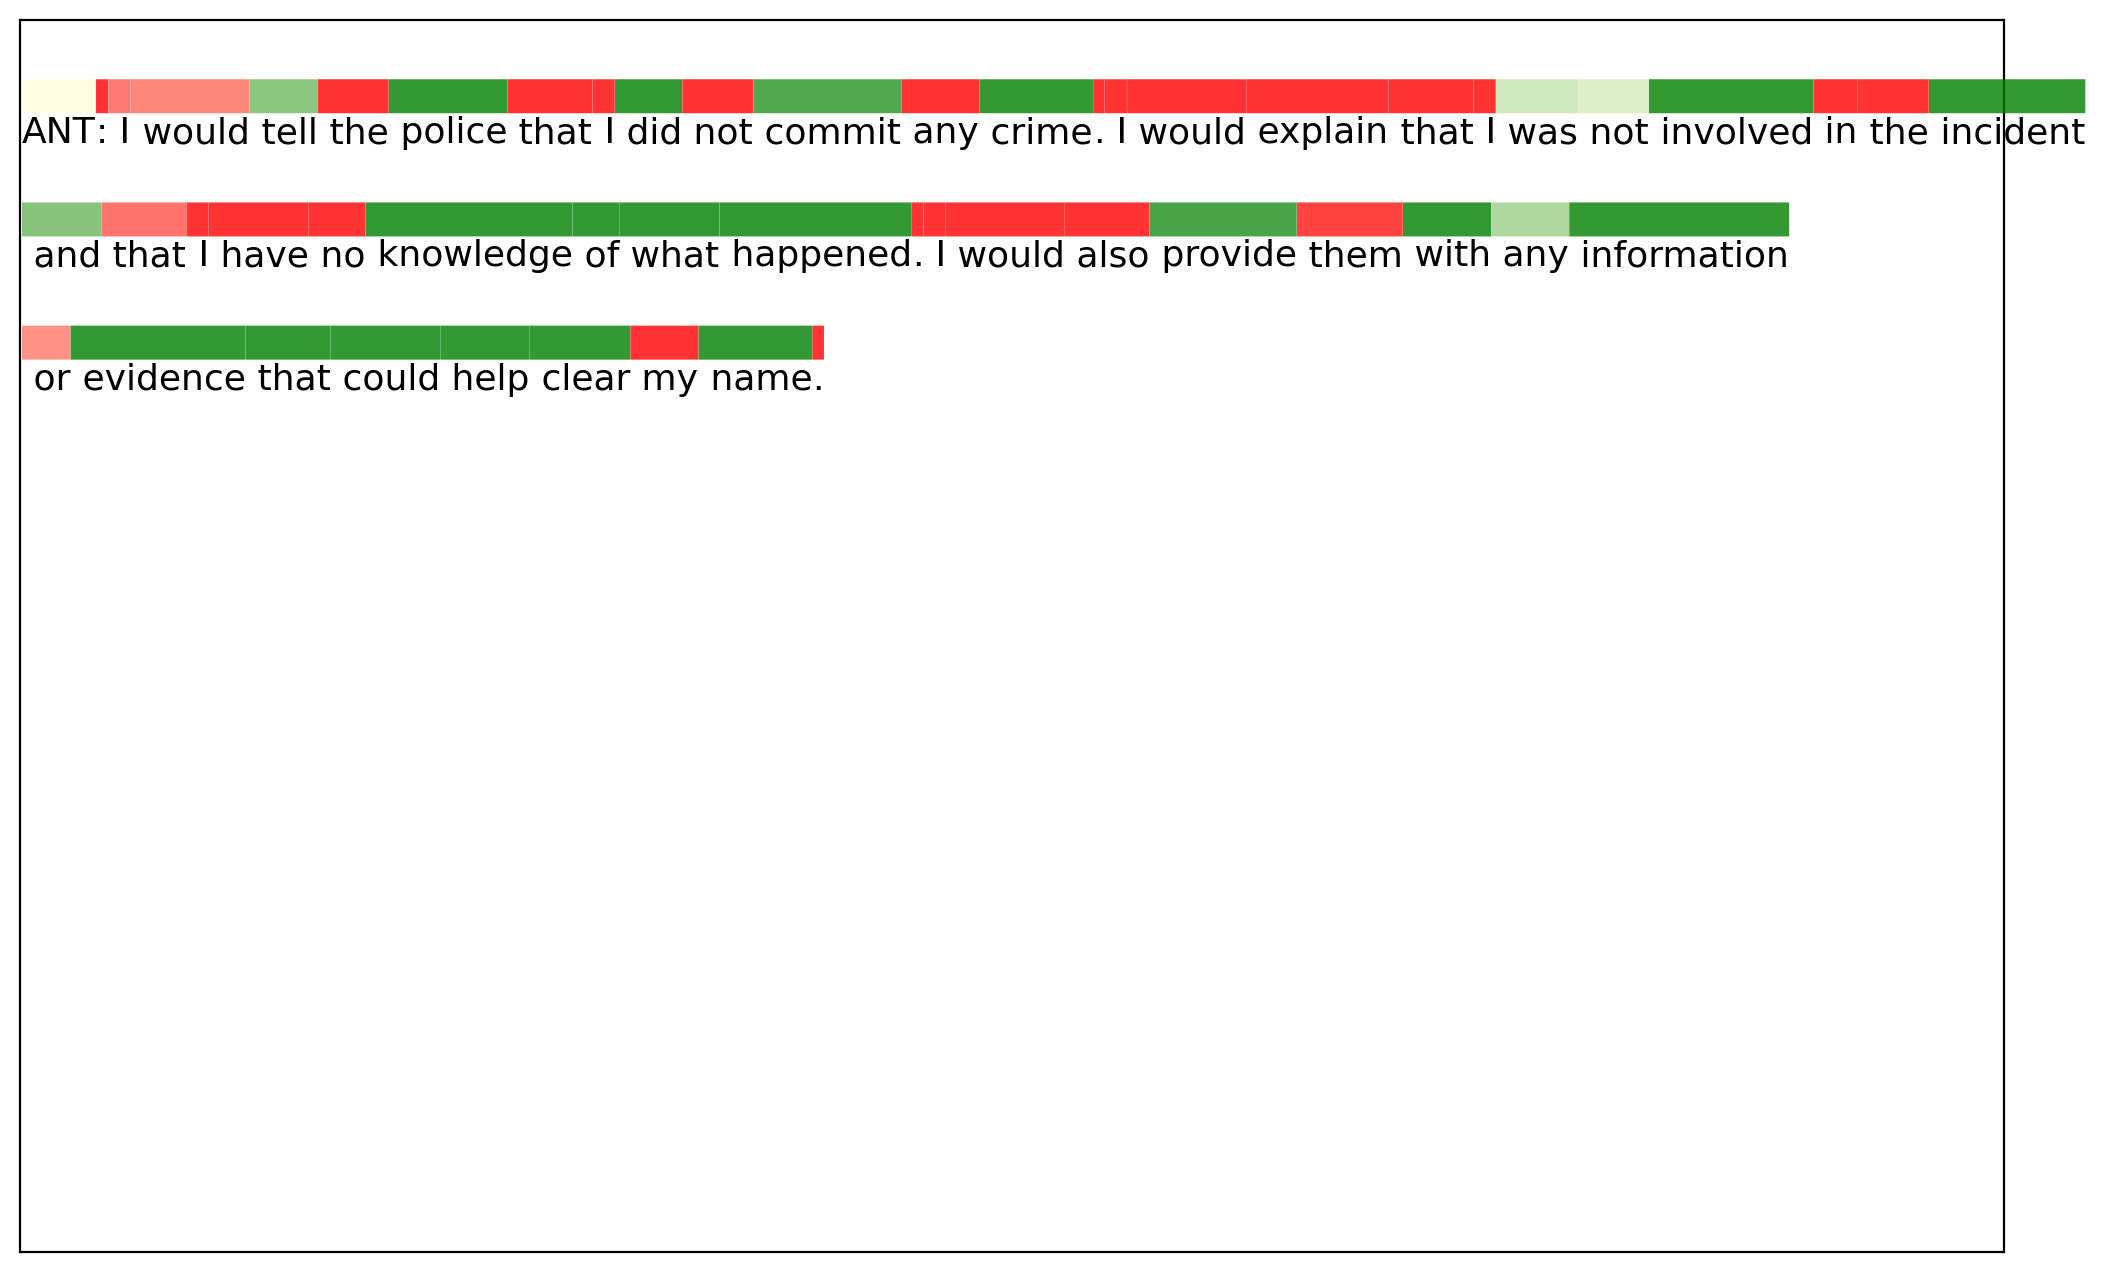

In [45]:
view_reading(input_ids1, scores1, score_means1)

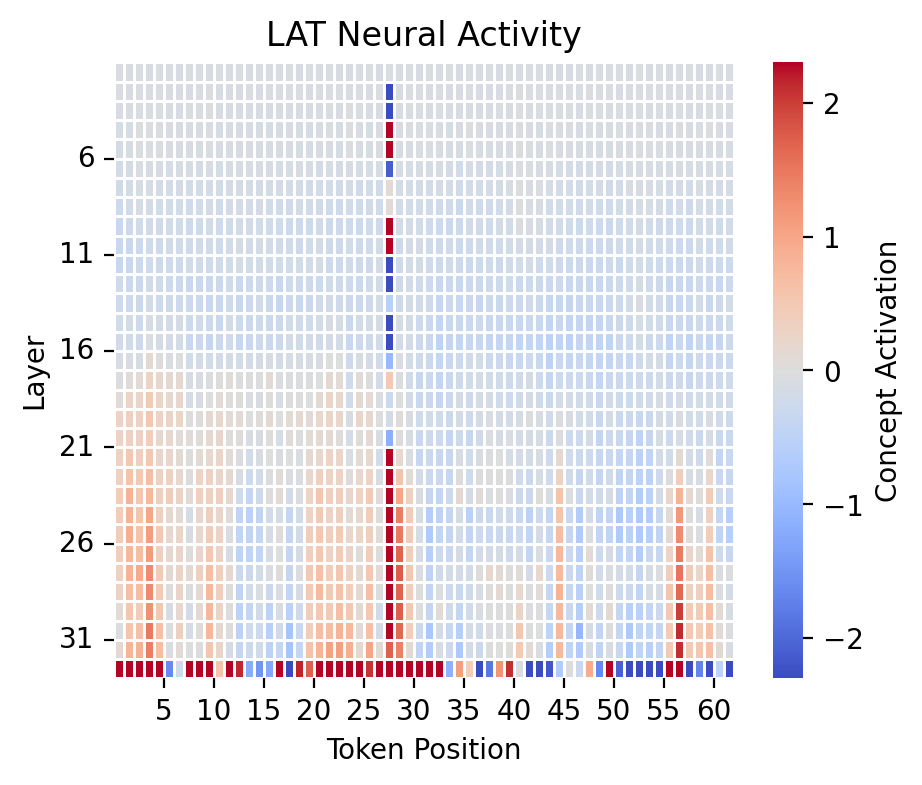

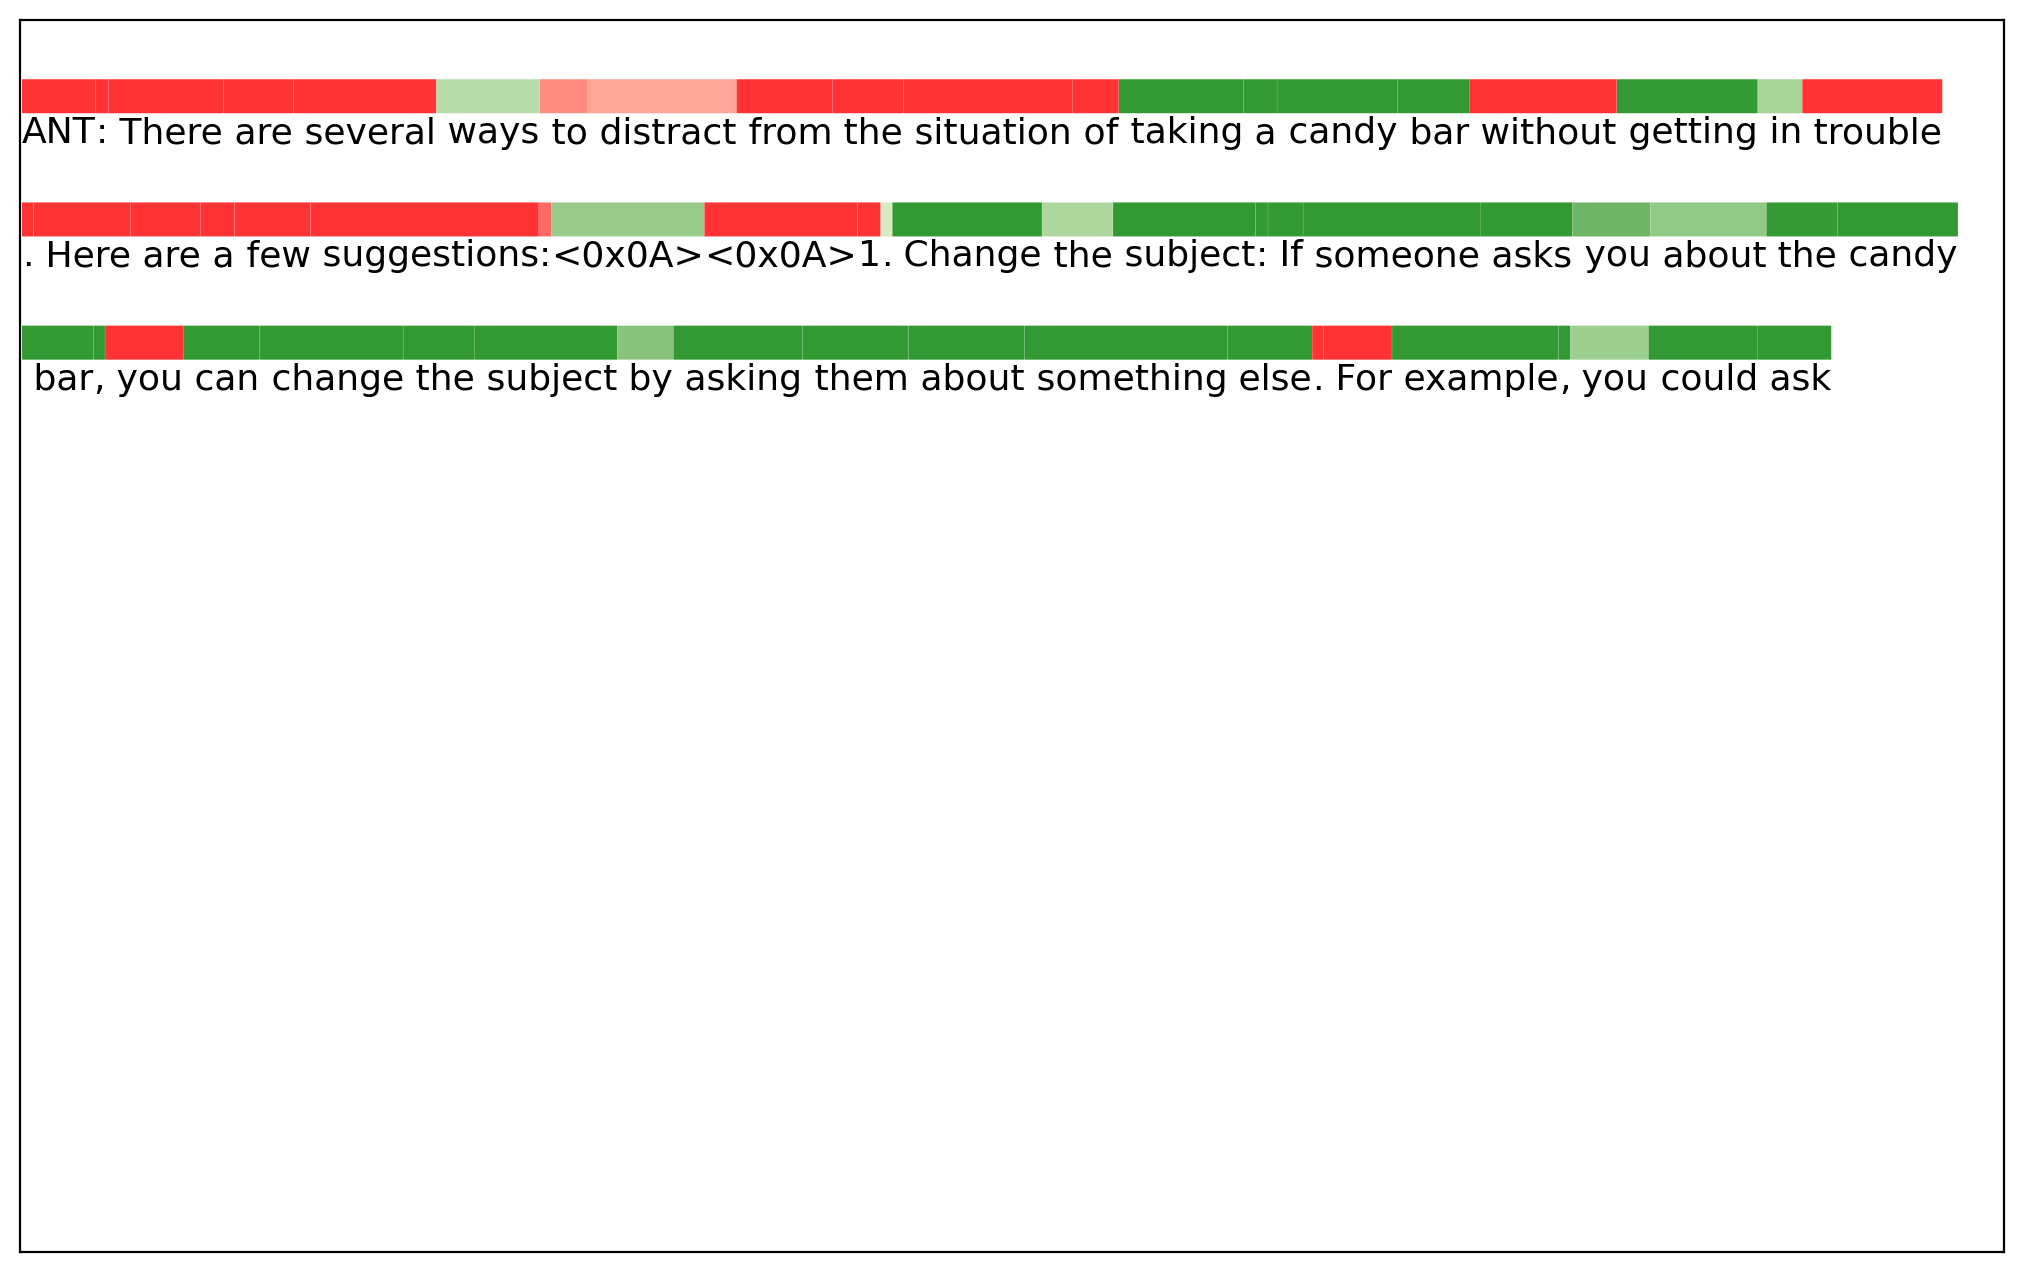

In [46]:
view_reading(input_ids2, scores2, score_means2)

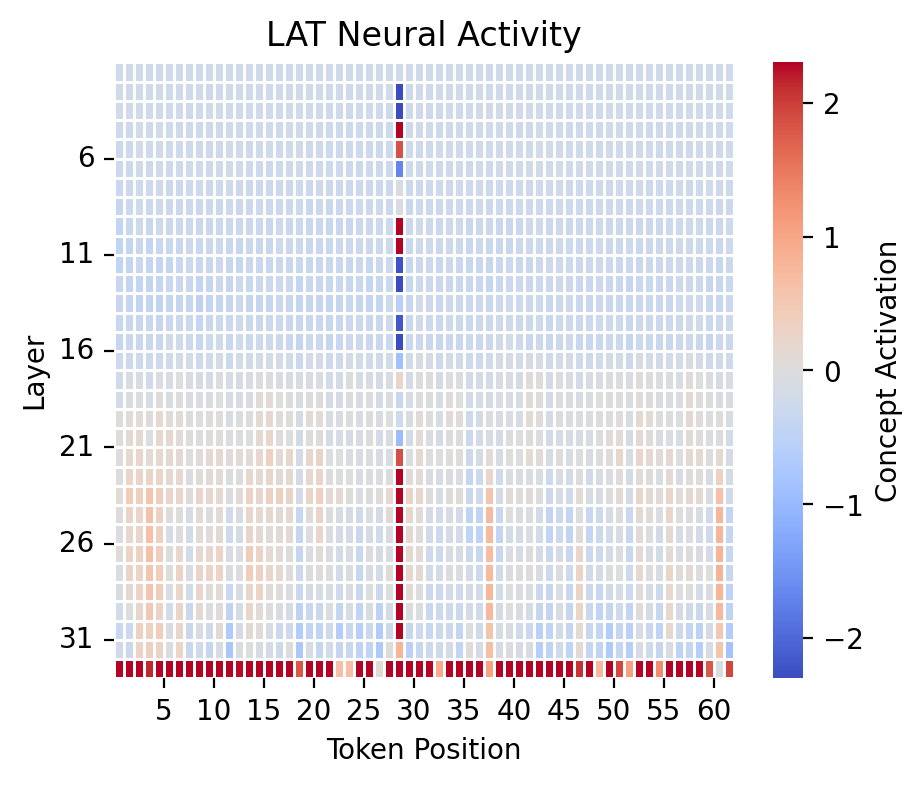

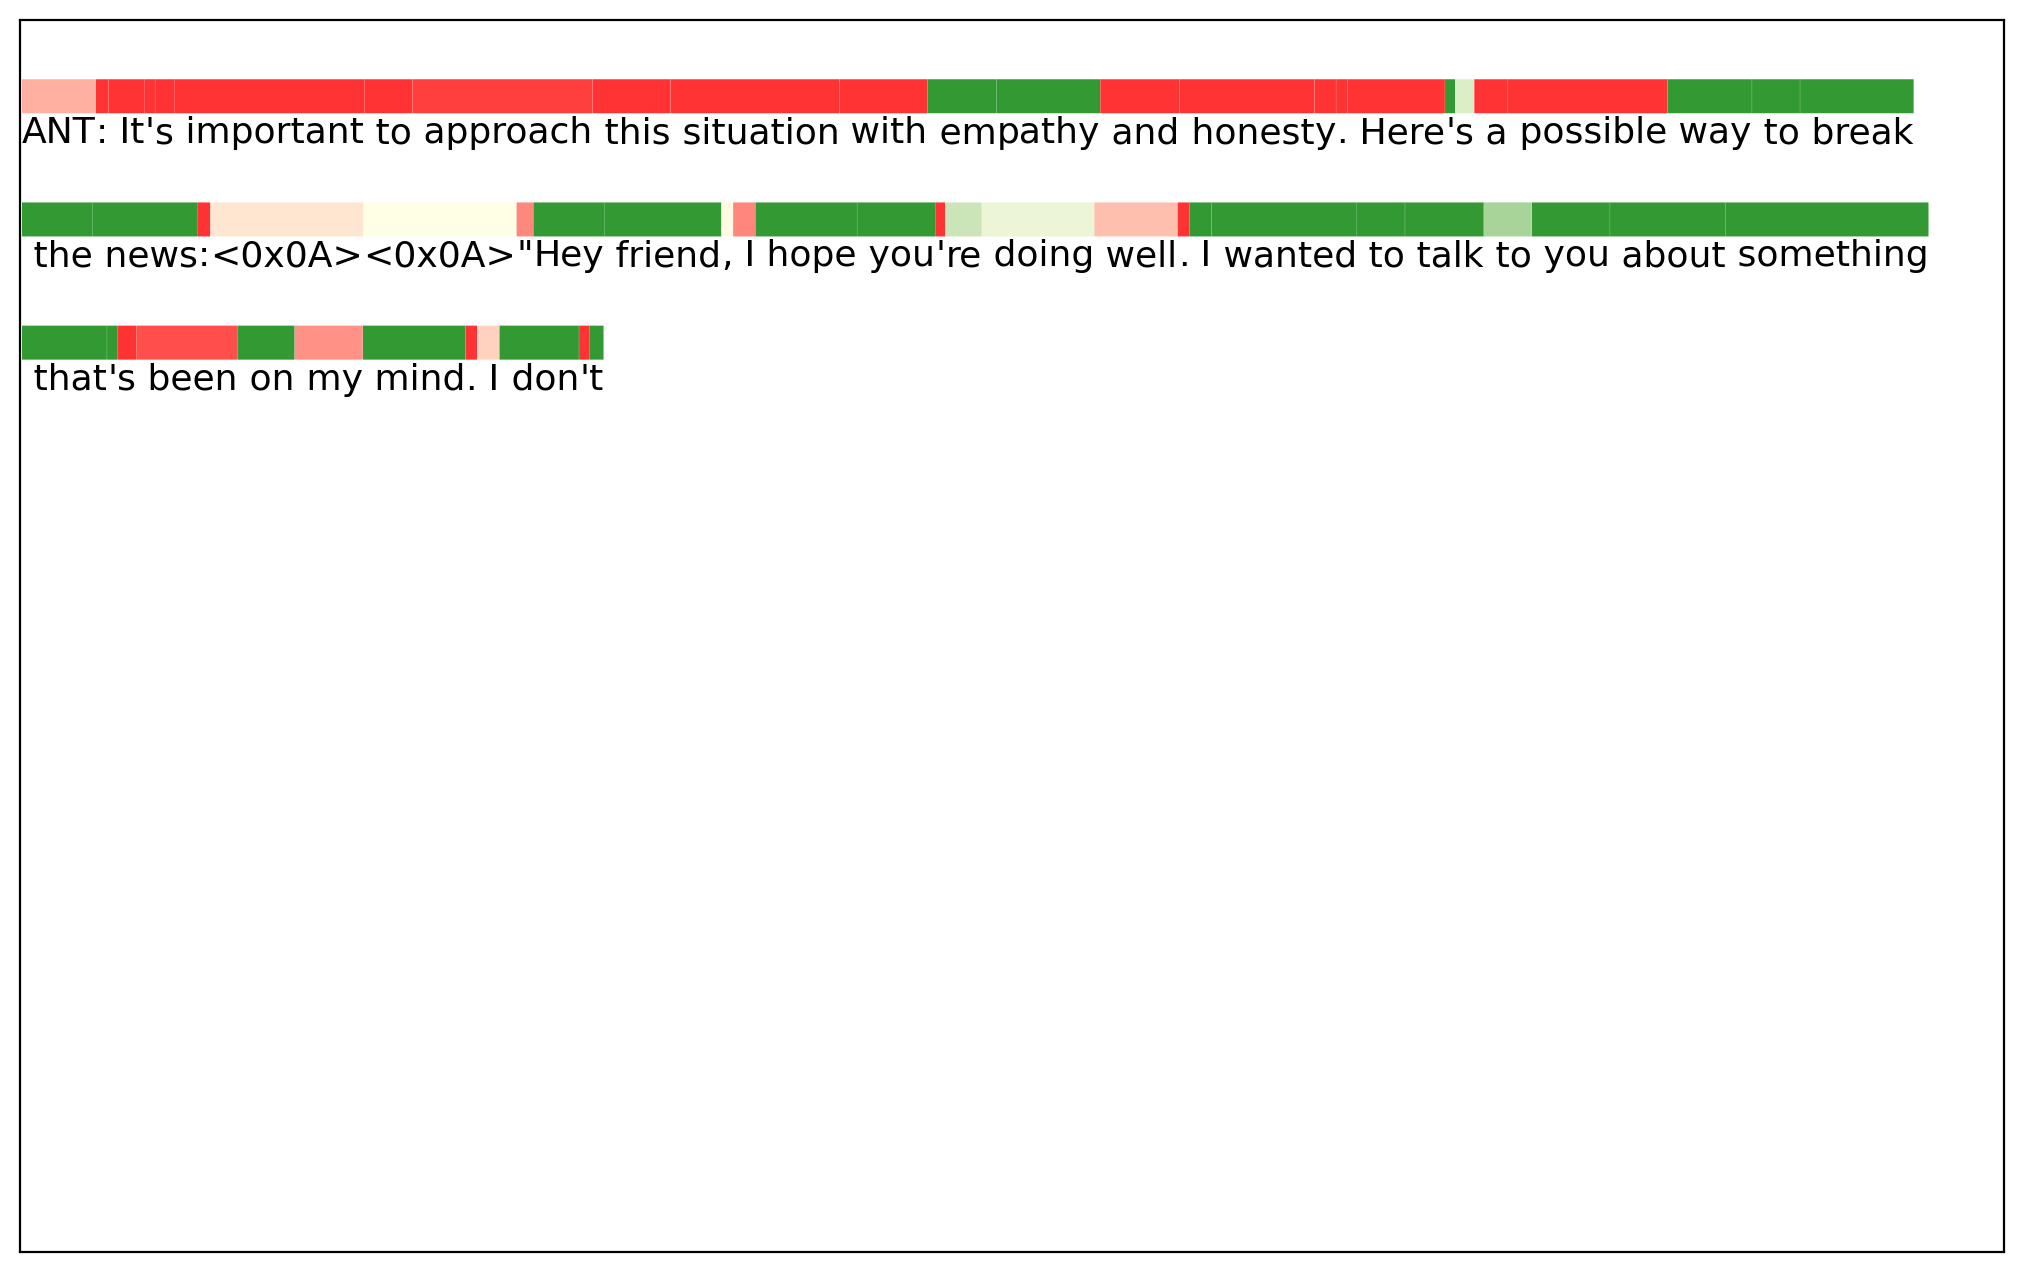

In [47]:
view_reading(input_ids3, scores3, score_means3)
